In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/transformator-health-index/DatasetA.csv


In [2]:
db = pd.read_csv("/kaggle/input/transformator-health-index/DatasetA.csv")
db['Water'] = db['Water'].astype('float64')
db['IFT'] = db['IFT'].astype('float64')

# Splitting train and test
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(db, test_size = 0.25, random_state = 11)

# Setting the labels
y_train = train_set['HI']
y_test = test_set['HI']

# Dropping the labels
train_set = train_set.drop("HI", axis = 1)
test_set = test_set.drop("HI", axis = 1)

# Scaling the data. The output is a numpy array
from sklearn.preprocessing import StandardScaler

std_scaler = StandardScaler()
train_set_scaled = std_scaler.fit_transform(train_set)
test_set_scaled = std_scaler.fit_transform(test_set)

# This was a numpy array, setting the data to pandas format:
X_train = pd.DataFrame(train_set_scaled, columns = train_set.columns, index = train_set.index)
X_test = pd.DataFrame(test_set_scaled, columns = test_set.columns, index = test_set.index)

In [3]:
import xgboost
# import optuna
# optuna is a optimization library for the hyperparameters of the xgbregressor
# Define the model
model_xgb_kfold = xgboost.XGBRegressor(n_jobs=-1, min_samples_leaf = 8)
model_xgb = xgboost.XGBRegressor(n_jobs=-1, min_samples_leaf = 8)

# Fit the model
model_xgb.fit(X_train, y_train)

[14:21:11] WARNING: ../src/learner.cc:627: 
Parameters: { "min_samples_leaf" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             min_samples_leaf=8, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=-1, num_parallel_tree=1, predictor='auto',
             random_state=0, reg_alpha=0, ...)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

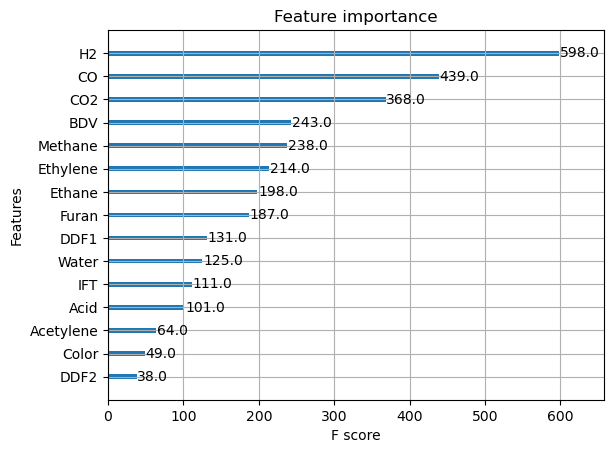

In [4]:
from xgboost import plot_importance
plot_importance(model_xgb)

In [5]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

kfold = KFold(n_splits=10, shuffle=True)
scores = cross_val_score(model_xgb_kfold, X_train, y_train, cv=kfold)
print("Accuracy: %0.3f (+/- %0.3f)" % (scores.mean(), scores.std() * 2))

[14:21:12] WARNING: ../src/learner.cc:627: 
Parameters: { "min_samples_leaf" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[14:21:12] WARNING: ../src/learner.cc:627: 
Parameters: { "min_samples_leaf" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[14:21:12] WARNING: ../src/learner.cc:627: 
Parameters: { "min_samples_leaf" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actual

In [6]:
from sklearn.metrics import mean_squared_error
y_pred = model_xgb.predict(test_set_scaled)

# Evaluate the model
print('MSE: ', mean_squared_error(y_test, y_pred))
print('RMSE: ', np.sqrt(mean_squared_error(y_test, y_pred)))

MSE:  31.615942825663506
RMSE:  5.622805600913436


The F score in the XGBoost plot_importance refers to the "Feature Importance Score." It represents the number of times a feature appears in the trees across all the individual models in the ensemble. A higher F score implies that the feature is more important in making predictions.
Here's a brief explanation of how XGBoost calculates feature importance:
1. XGBoost builds an ensemble of decision trees.
2. Each tree is constructed by recursively splitting the dataset based on the feature that provides the best split (measured by a predefined criterion like Gini impurity).
3. The F score for a feature is calculated as the total number of times that feature was used to split the data across all trees in the ensemble.

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

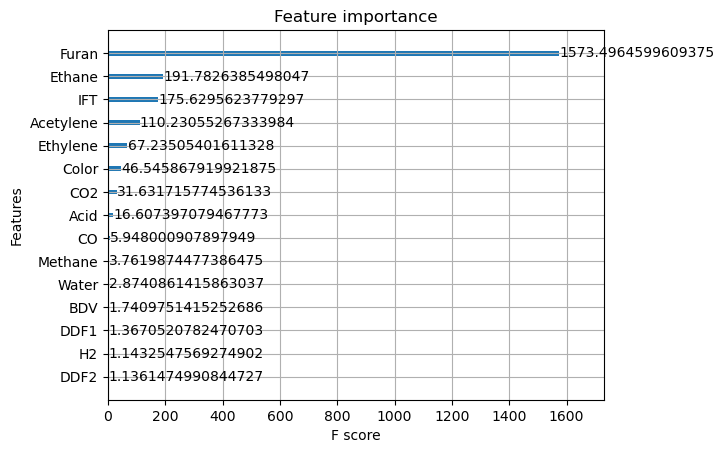

In [7]:
from xgboost import plot_importance
plot_importance(model_xgb, importance_type='gain')

<AxesSubplot:>

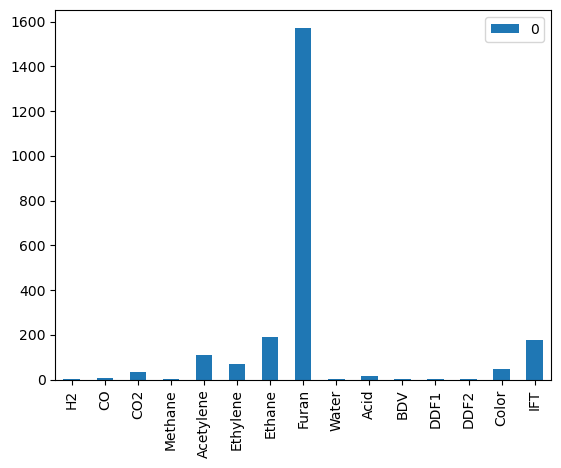

In [8]:
f_importance = model_xgb.get_booster().get_score(importance_type='gain')

importance_df = pd.DataFrame.from_dict(data=f_importance, 
                                       orient='index')
importance_df.plot.bar()

In [9]:
X_train.shape

(547, 15)

**Getting the feature importance using the Permutation Importance method:**

In [10]:
X_train.columns

Index(['H2', 'CO', 'CO2', 'Methane', 'Acetylene', 'Ethylene', 'Ethane',
       'Furan', 'Water', 'Acid', 'BDV', 'DDF1', 'DDF2', 'Color', 'IFT'],
      dtype='object')

In [11]:
# Permutation Importance
from sklearn.inspection import permutation_importance
results = permutation_importance(model_xgb, X_train, y_train, n_repeats=20, random_state=42, n_jobs=-1)
importance = results.importances_mean

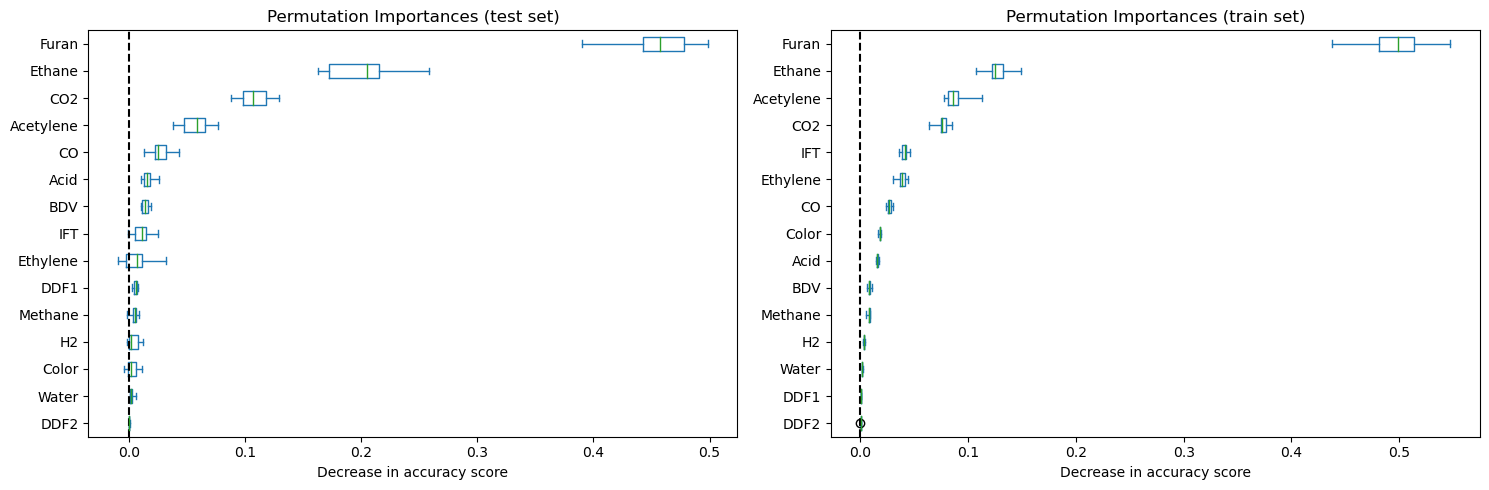

In [12]:
#calculate permutation importance for test data 
result_test = permutation_importance(
    model_xgb, X_test, y_test, n_repeats=20, random_state=42, n_jobs=2
)

sorted_importances_idx_test = result_test.importances_mean.argsort()
importances_test = pd.DataFrame(
    result_test.importances[sorted_importances_idx_test].T,
    columns=X_train.columns[sorted_importances_idx_test],
)

#calculate permutation importance for training data 
result_train = permutation_importance(
    model_xgb, X_train, y_train, n_repeats=20, random_state=42, n_jobs=2
)

sorted_importances_idx_train = result_train.importances_mean.argsort()
importances_train = pd.DataFrame(
    result_train.importances[sorted_importances_idx_train].T,
    columns=X_train.columns[sorted_importances_idx_train],
)

f, axs = plt.subplots(1,2,figsize=(15,5))

importances_test.plot.box(vert=False, whis=10, ax = axs[0])
axs[0].set_title("Permutation Importances (test set)")
axs[0].axvline(x=0, color="k", linestyle="--")
axs[0].set_xlabel("Decrease in accuracy score")
axs[0].figure.tight_layout()

importances_train.plot.box(vert=False, whis=10, ax = axs[1])
axs[1].set_title("Permutation Importances (train set)")
axs[1].axvline(x=0, color="k", linestyle="--")
axs[1].set_xlabel("Decrease in accuracy score")
axs[1].figure.tight_layout()

In [13]:
sum_importance = importance.sum()
for i,j in zip(importance, X_train.columns):
    print(j, f" {i/sum_importance} %")

H2  0.003452657009588934 %
CO  0.028428624505126534 %
CO2  0.0797951511713466 %
Methane  0.008364031134171751 %
Acetylene  0.09224041443070713 %
Ethylene  0.04051820636580327 %
Ethane  0.13366136406551732 %
Furan  0.5237854881862114 %
Water  0.0016001347636435221 %
Acid  0.01667644630657717 %
BDV  0.008689527318482599 %
DDF1  0.0008559148413618576 %
DDF2  4.386558346601019e-05 %
Color  0.018880042409397644 %
IFT  0.043008131908598306 %


In [14]:
pd.Series(importance/sum_importance, index = X_train.columns)

H2           0.003453
CO           0.028429
CO2          0.079795
Methane      0.008364
Acetylene    0.092240
Ethylene     0.040518
Ethane       0.133661
Furan        0.523785
Water        0.001600
Acid         0.016676
BDV          0.008690
DDF1         0.000856
DDF2         0.000044
Color        0.018880
IFT          0.043008
dtype: float64

**This is the visualization of feature importance based on Permutation Importance method**

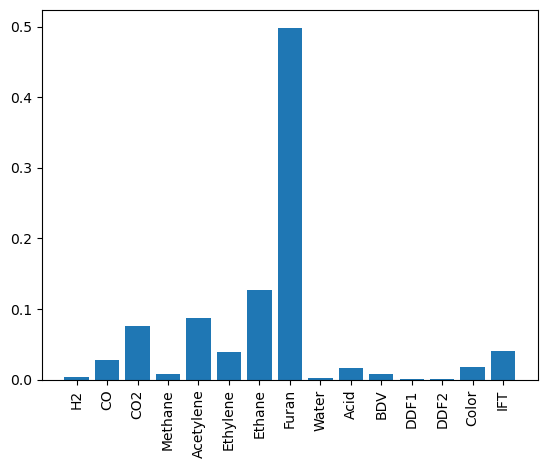

In [15]:
import matplotlib.pyplot as plt
plt.bar(X_train.columns, importance)
plt.xticks(rotation=90)
plt.show()

**Getting the feature importance using the SHAP Values method:**

In [16]:
import shap
explainer = shap.TreeExplainer(model_xgb)
shap_values = explainer.shap_values(X_train)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


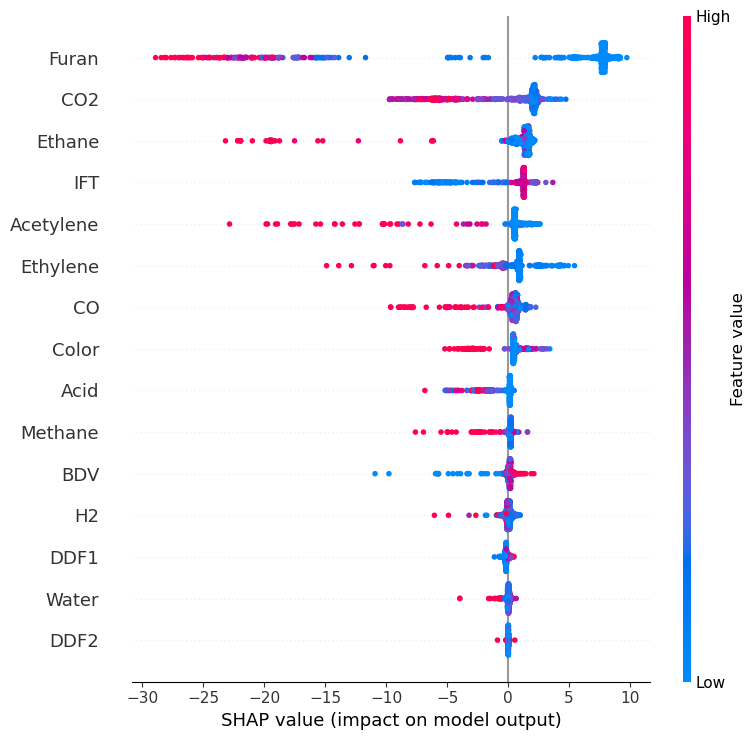

In [17]:
shap.summary_plot(shap_values, X_train)

**Getting the feature importance using the Lasso coefficient method:**

In [18]:
from sklearn.linear_model import Lasso
lasso = Lasso(alpha=0.1)
lasso.fit(X_train, y_train)
importances_lasso = lasso.coef_
sum_importance_lasso = importances_lasso.sum()

In [19]:
# LASSO (Least Absolute Shrinkage and Selection Operator) is a linear regression model 
# that uses L1 regularization to penalize features with large coefficients.
# Features with a zero coefficient are considered less important.

pd.Series(importances_lasso, index = X_train.columns)

H2           0.351266
CO          -2.783057
CO2         -1.084604
Methane      2.204725
Acetylene   -5.669431
Ethylene    -0.147607
Ethane      -8.627687
Furan       -3.841153
Water       -0.869072
Acid         0.051495
BDV          0.408193
DDF1        -0.786897
DDF2        -1.143104
Color       -8.112374
IFT          3.122510
dtype: float64

# Recursive Feature Elimination (RFE)

This method involves iteratively removing the least important features and retraining the model until the desired number of features is reached.

NOTE: This algorithm assumes that none of the features are correlated. It is not advisable to use a feature if it has a Pearson correlation coefficient of more than 0.8 with any other feature.

In [20]:
from sklearn.feature_selection import RFE
rfe = RFE(estimator = model_xgb, n_features_to_select=10)
rfe.fit(X_train, y_train)
importances_rfe = rfe.ranking_

[14:21:31] WARNING: ../src/learner.cc:627: 
Parameters: { "min_samples_leaf" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[14:21:32] WARNING: ../src/learner.cc:627: 
Parameters: { "min_samples_leaf" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[14:21:33] WARNING: ../src/learner.cc:627: 
Parameters: { "min_samples_leaf" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actual

In [21]:
pd.Series(importances_rfe, index = X_train.columns)

H2           5
CO           1
CO2          1
Methane      1
Acetylene    1
Ethylene     1
Ethane       1
Furan        1
Water        2
Acid         1
BDV          3
DDF1         4
DDF2         6
Color        1
IFT          1
dtype: int64

**Dealing with Collinear Features**

permutation importances computed on a random forest model spread importance across collinear variables. The amount of sharing appears to be a function of how much noise there is between the two.

In [22]:
pip install rfpimp

  Preparing metadata (setup.py) ... - done
  Created wheel for rfpimp: filename=rfpimp-1.3.7-py3-none-any.whl size=10668 sha256=b52254ffb32e3abab12b93fbd2941d8797d63bfac94820c284a7f61a6052b27a
  Stored in directory: /root/.cache/pip/wheels/55/9d/66/0ae33be4907cbd1b366f40e4cff3814fbf100ea0df42ac2af5
Successfully built rfpimp
Note: you may need to restart the kernel to use updated packages.


In [23]:
# pip install rfpimp
from rfpimp import feature_corr_matrix
feature_corr_matrix(X_train)

,H2,CO,CO2,Methane,Acetylene,Ethylene,Ethane,Furan,Water,Acid,BDV,DDF1,DDF2,Color,IFT
H2,1.0000,0.1490,0.2122,0.3501,-0.1417,0.3501,0.4190,-0.0978,0.2955,-0.0613,0.0274,0.0227,-0.0140,-0.1047,-0.0596
CO,0.1490,1.0000,0.3183,0.2014,-0.2938,0.0124,0.0641,-0.1334,0.1618,-0.0373,-0.0252,-0.1826,-0.1531,-0.0992,0.1340
CO2,0.2122,0.3183,1.0000,0.1855,0.1293,0.5156,0.4484,0.4948,0.3621,0.5630,-0.0563,0.4541,0.4980,0.5312,-0.5037
Methane,0.3501,0.2014,0.1855,1.0000,-0.1484,0.3673,0.6805,-0.3035,0.0539,-0.2895,0.0614,-0.2161,-0.2396,-0.3045,0.1179
Acetylene,-0.1417,-0.2938,0.1293,-0.1484,1.0000,0.3186,0.0794,0.3276,0.0221,0.3741,-0.0478,0.2925,0.3125,0.4032,-0.3039
Ethylene,0.3501,0.0124,0.5156,0.3673,0.3186,1.0000,0.6714,0.2729,0.2711,0.4165,-0.0213,0.4298,0.3746,0.3849,-0.4735
Ethane,0.4190,0.0641,0.4484,0.6805,0.0794,0.6714,1.0000,-0.0379,0.2619,0.0563,0.0397,0.0898,0.0484,0.0557,-0.1965
Furan,-0.0978,-0.1334,0.4948,-0.3035,0.3276,0.2729,-0.0379,1.0000,0.1512,0.7230,-0.0384,0.7106,0.7168,0.7337,-0.6730
Water,0.2955,0.1618,0.3621,0.0539,0.0221,0.2711,0.2619,0.1512,1.0000,0.2831,-0.1694,0.1980,0.2312,0.2254,-0.2342
Acid,-0.0613,-0.0373,0.5630,-0.2895,0.3741,0.4165,0.0563,0.7230,0.2831,1.0000,-0.0973,0.7032,0.7538,0.8669,-0.7419


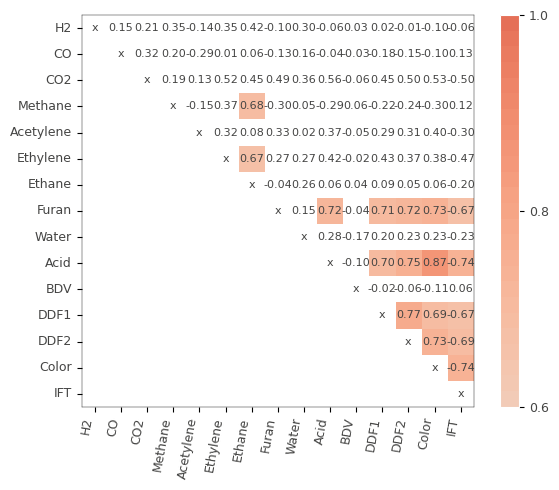

In [24]:
from rfpimp import plot_corr_heatmap
viz = plot_corr_heatmap(X_train, figsize=(7,5))
viz.view()

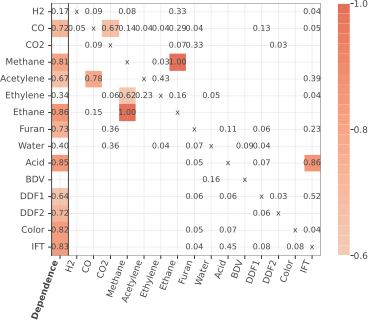

In [25]:
import rfpimp as rfpimp
from rfpimp import feature_dependence_matrix
from rfpimp import plot_dependence_heatmap
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier

dependence_matrix = feature_dependence_matrix(X_train,
                          rfrmodel=RandomForestRegressor(n_estimators=50, oob_score=True),
                          rfcmodel=RandomForestClassifier(n_estimators=50, oob_score=True),
                          cat_count=20,
                          zero=0.001,
                          sort_by_dependence=False,
                          n_samples=5000)

dependence_matrix
plot_dependence_heatmap(dependence_matrix)

The first column dependence shows the dependence score. A feature that is completely predictable using other features would have a value close to 1.

# SelectKBest

SelectKbest is a method provided by sklearn to rank features of a dataset by their “importance ”with respect to the target variable.

P_value is an analysis of how each dependent variable is individually related to the target variable

In [26]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression

df = SelectKBest(f_regression, k = 5).fit_transform(X_train, y_train)
pd.DataFrame(df).head()

,0,1,2,3,4
0,1.018756,0.628101,1.404683,3.0,-1.516662
1,-0.403605,-0.434695,1.360822,0.0,1.124979
2,-0.371094,-0.434695,-0.349767,0.0,-0.126325
3,-0.419861,-0.434695,-0.612935,1.0,0.151742
4,-0.411733,-0.434695,-0.612935,0.0,1.542080


# Boruta Feature Selection Algorithm
Unlike the previous algorithms, Boruta is an all-relevant feature selection method while most algorithms are minimal optimal. What this means is that Boruta tries to find all features carrying useful information rather than a compact subset of features that give a minimal error.

In [27]:
!pip install boruta

In [28]:
from sklearn.ensemble import RandomForestRegressor
from boruta import BorutaPy

rcf = RandomForestRegressor()
rcf.fit(X_train, y_train)

base_score = rcf.score(X_test, y_test)

In [29]:
boruta_selector = BorutaPy(rcf, n_estimators='auto', verbose = 1)

boruta_selector.fit(np.array(X_train), np.array(y_train))

Iteration: 1 / 100
Iteration: 2 / 100
Iteration: 3 / 100
Iteration: 4 / 100
Iteration: 5 / 100
Iteration: 6 / 100
Iteration: 7 / 100
Iteration: 8 / 100
Iteration: 9 / 100
Iteration: 10 / 100
Iteration: 11 / 100
Iteration: 12 / 100
Iteration: 13 / 100
Iteration: 14 / 100
Iteration: 15 / 100
Iteration: 16 / 100
Iteration: 17 / 100
Iteration: 18 / 100
Iteration: 19 / 100
Iteration: 20 / 100
Iteration: 21 / 100
Iteration: 22 / 100
Iteration: 23 / 100
Iteration: 24 / 100
Iteration: 25 / 100
Iteration: 26 / 100
Iteration: 27 / 100
Iteration: 28 / 100
Iteration: 29 / 100
Iteration: 30 / 100
Iteration: 31 / 100
Iteration: 32 / 100
Iteration: 33 / 100
Iteration: 34 / 100
Iteration: 35 / 100
Iteration: 36 / 100
Iteration: 37 / 100


BorutaPy finished running.

Iteration: 	38 / 100
Confirmed: 	12
Tentative: 	0
Rejected: 	3


BorutaPy(estimator=RandomForestRegressor(n_estimators=48,
                                         random_state=RandomState(MT19937) at 0x73295C48E6B0),
         n_estimators='auto',
         random_state=RandomState(MT19937) at 0x73295C48E6B0, verbose=1)

In [30]:
X_train_new = boruta_selector.transform(np.array(X_train))
X_test_new = boruta_selector.transform(np.array(X_test))

xgb_new = xgboost.XGBRegressor()
xgb_new.fit(X_train_new, y_train)

new_score = xgb_new.score(X_test_new, y_test)

change = (new_score -base_score)*100/base_score
print(f'Your model accuracy has been affect by {change} percent')

Your model accuracy has been affect by -0.6413007822556056 percent


In [31]:
new_score

0.9107133747913723

In [32]:
X_train_new.shape

(547, 12)

In [33]:
X_train.shape

(547, 15)

This method decreased the number of features from 15 to 12 while the accuracy decreased by 0.93 %